# Homework #6 (Due 10/23/2019, 11:59pm)
## Generalized Linear Models in `pymc3`

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [0]:
# Import basic libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pymc3 as pm
import sklearn as sk
import scipy as st
import time

# Plot configs
fig_wide = (11, 4)
%config InlineBackend.figure_format = "retina"

In [0]:
%matplotlib inline
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

In [3]:
!pip install arviz

## Problem Description: A Study of Census Data

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). 

You will be investigate the effect of the marital status on a person's yearly income in the dataset. In particular, we want to know how a person's marital status affect the likelihood of their yearly salary being above or below \$50k. 

This analysis is a direct replica of the one in Example 10.1.3 in "Statistical Rethinking" (the excerpt of which is included in the data directory for this assignment). Example 10.1.3,illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

The data you've been given has been aggregate into seven different categories. The categories represent: 

- Category 1: 4 year college degree
- Category 2: Some-college or two year academic college degree
- Category 3: Professional or vocational school degree
- Category 4: High school degree
- Category 5: Did not complete high school
- Category 6: Masters 
- Category 7: Doctorate


For each category, we've only kept track of a count of the number of maried and unmarried individuals who make above (and resp. below) \\$50k and the total number of people in the category. 

### Part I: Analysis of the Effect of Marital Status

You will build two models to predict an individual's yearly income (1 being above \\$50k and 0 being below), one of these models should include the effect of marital status while the other should not.

**Model 1 (Includes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k and let $M_n$ be a binary indicator of the marital status of the $n$-th observation (1 indicates "married" and 0 otherwise).

\begin{aligned}
\beta &\sim \mathcal{N}(0, 10)\\
\alpha &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha + \beta M_n)\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

**Model 2 (Excludes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k.

\begin{aligned}
\alpha &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha)\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

1. Implement Model 1 and Model 2 in `pymc3`. To implement a mathematical function $a = f(b)$ in `pymc3`, you must use `a = pymc3.Deterministic('a', [your pymc3 implementation of f])`, where $f$ is implemented using `pymc3.math` functions.

  Compute the advantage or disadvantage of being married for high earning in terms of odds.

  Perform a WAIC comparison for the two models -- use `pymc3.waic`. 
  
  Based on the above, make a hypothesis about the effect of an individual's marital status on their income. <br><br>

2.  Make a plot like Figure 10.5 to perform a posterior predictive check (see how well your models fits the data). Specifically, for each category: 
  - plot the observed percentage of married individuals making over \\$50k and unmarried individuals making over \\$50k.
  - on the same plot, plot the posterior mean and posterior 95\% predictive interval (in percentages) of married individuals making over \\$50k and unmarried individuals making over \\$50k.
  
  Based on your posterior predictive check, are you more or less confident in the validity of your hypothesis regarding the relationship between marital status and income?

#### 1.1 Implement Model 1 and Model 2 in `pymc3`

Model 1 and Model 2 can be implemented with `pymc3`'s intuitive interface below.

In [0]:
# load data
df = pd.read_csv("HW6_data.csv")
M, T, obs = df["married"], df["total"], df[">50"]

# Model 1
with pm.Model() as model_1:
    beta = pm.Normal("beta", mu=0, sigma=n
    alpha = pm.Normal("alpha", mu=0, sigma=np.sqrt(10))
    mu = pm.Deterministic("mu", alpha + pm.math.dot(beta, M))
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Binomial("y_obs", n=T, p=theta, observed=obs)
    
# Model 2
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=np.sqrt(10))
    mu = pm.Deterministic("mu", alpha)
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Binomial("y_obs", n=T, p=theta, observed=obs)

$\mu$ is an auxiliary distribution to help us visualize the linearized model input into $\theta$. The graphical network for both hierarchical models are shown below.

Model 1:


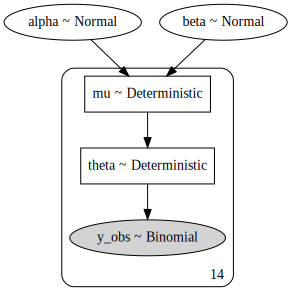

Model 2:


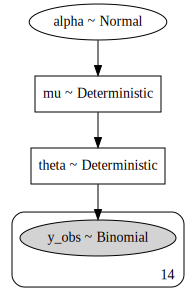

In [5]:
print("Model 1:")
display(pm.model_to_graphviz(model_1))
print("Model 2:")
display(pm.model_to_graphviz(model_2))

Running the sampler next, we get the following traces for the parameters

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]
100%|██████████| 8000/8000 [00:08<00:00, 937.05it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha]
100%|██████████| 8000/8000 [00:04<00:00, 1967.38it/s]


Model 1:


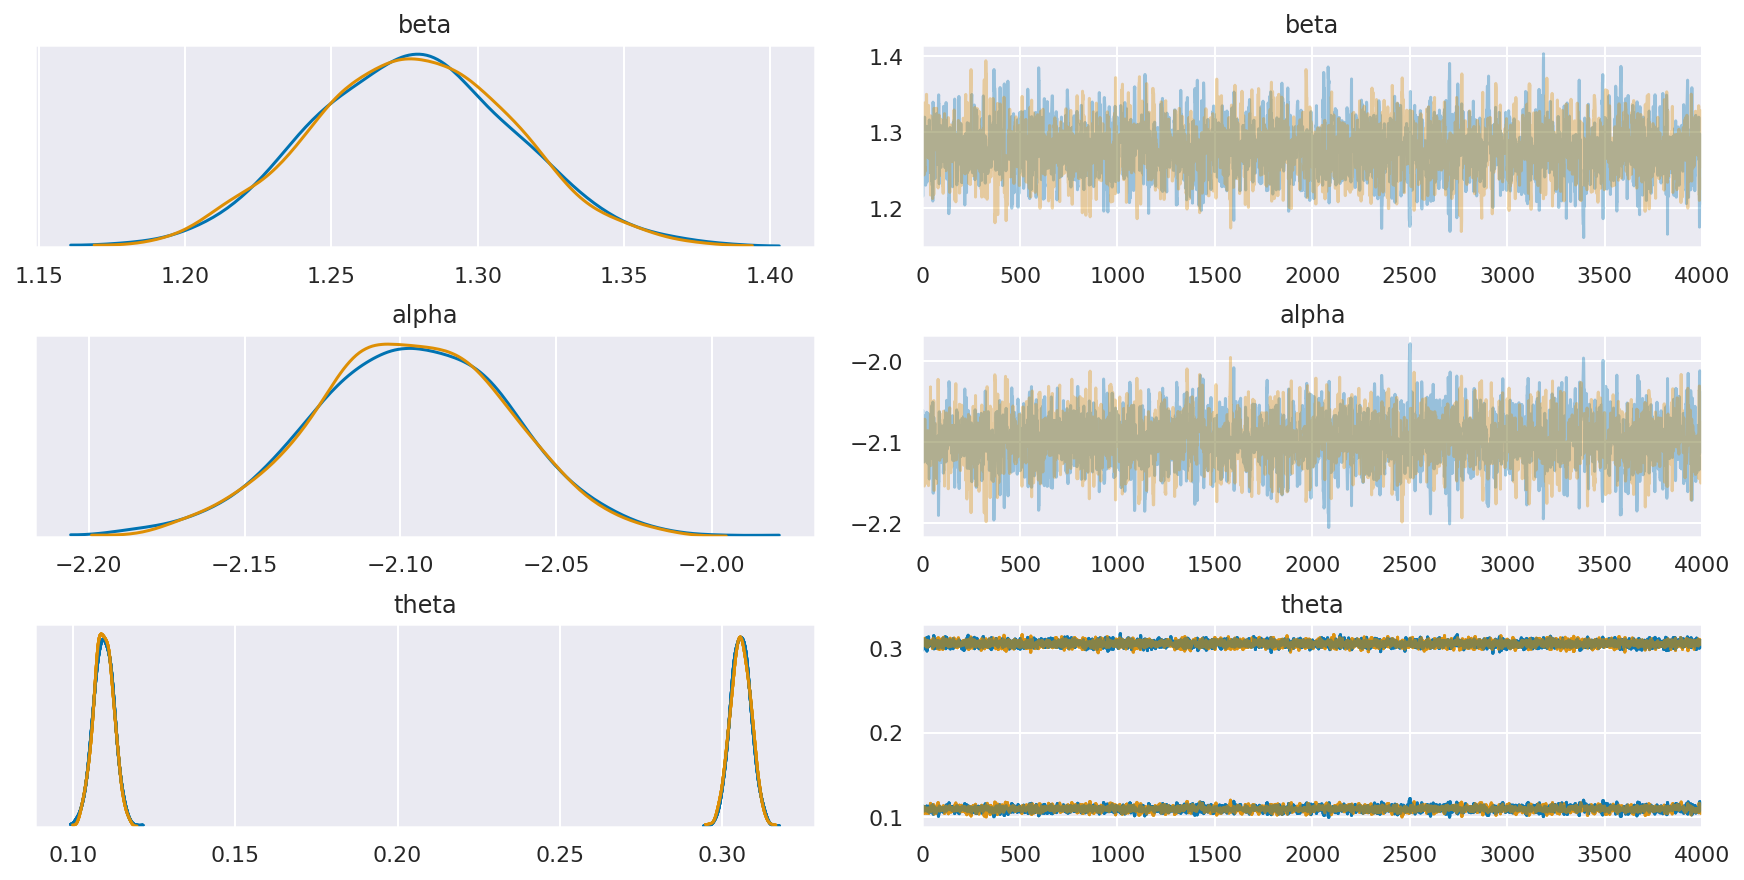

Model 2:


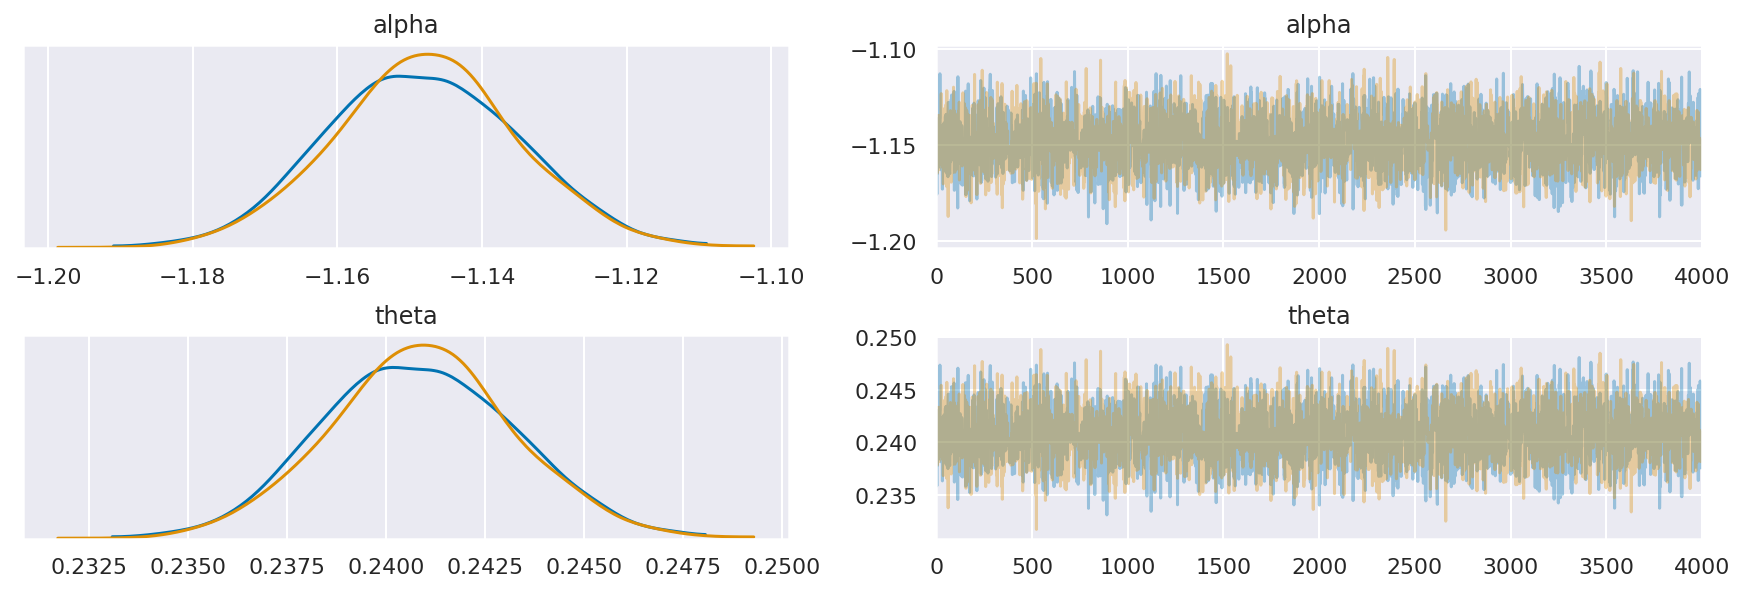

In [6]:
# run sampler on each model
with model_1:
    tryace_1 = pm.sample(4000, tune=4000)
with model_2:
    trace_2 = pm.sample(4000, tune=4000)

# display trace results
print("Model 1:")
pm.traceplot(trace_1, var_names=["beta", "alpha", "theta"], compact=True)
plt.show()
print("Model 2:")
pm.traceplot(trace_2, var_names=["alpha", "theta"], compact=True)
plt.show()

We see two distinct peaks for $\theta$ in Model 1 while only one for Model 2 in the trace plots. The Widely-applicable Information Criterion (WAIC) for each model is: 

In [7]:
print("Model 1:")
print(pm.waic(trace_1, model_1).WAIC)
print("Model 2:")
print(pm.waic(trace_2, model_2).WAIC)

Model 1:


/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


4623.788019326304
Model 2:
6191.681251330995


The WAIC for Model 1 is a bit smaller than the WAIC for Model 2, indicating that Model 1 fits the data better.

#### 1.2 Posterior Predictive Plot

Taking a look at the posterior predictive next we the following for each model:

100%|██████████| 500/500 [00:00<00:00, 1295.56it/s]


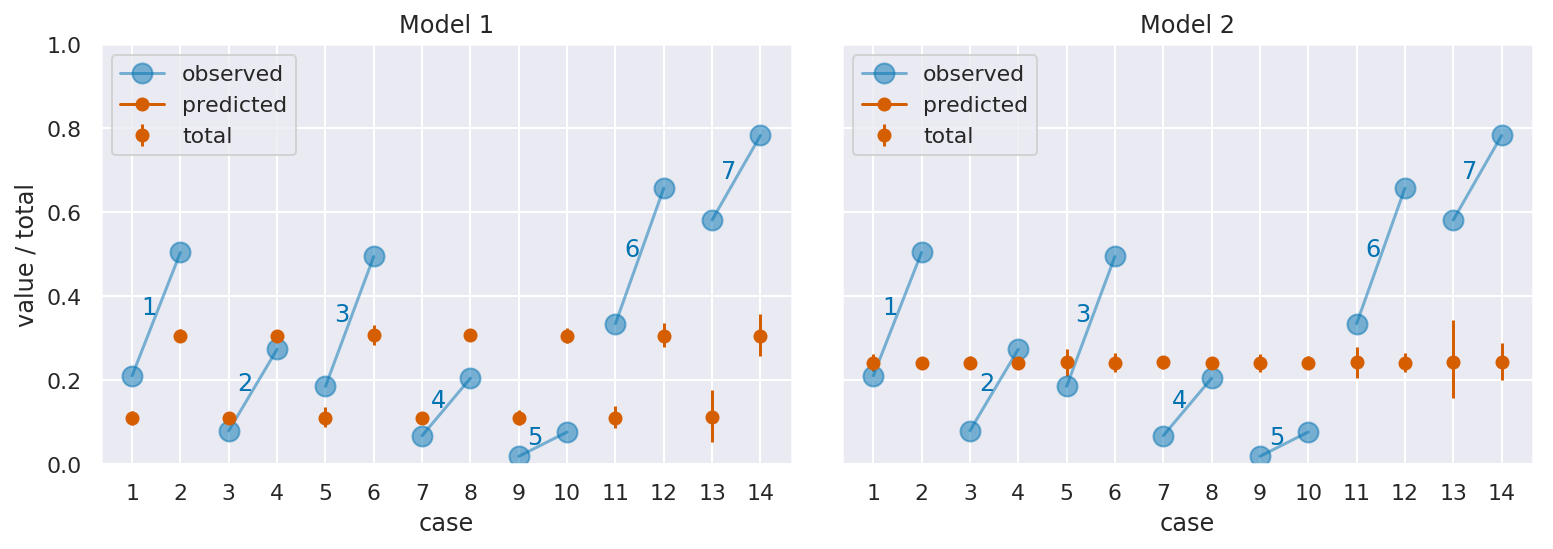

In [8]:
# compute posterior predictive
ppc_1 = pm.sample_posterior_predictive(trace_1, samples=500, model=model_1)
ppc_2 = pm.sample_posterior_predictive(trace_2, samples=500, model=model_2)

# connects points in the same category with a line
def plot_connected(ax, x, **kwargs):
    for i in range(0, len(x), 2):
        ax.plot(x[i:i+2], "-o", **kwargs)
        ax.annotate(int(i/2)+1, (i+0.5, np.median(x[i:i+2])), ha="right", color='b')
    
# gets mean, -/+ for 1D dist
def get_ci(dist, c=95):
    bound = (100 - c) / 2
    mean = np.mean(dist)
    upper, lower = np.percentile(dist, 100 - bound), np.percentile(dist, bound)
    return mean, mean - lower, upper - mean

# gets mean, -/+ for each 1D dist in array of dists, where each column is one
# result is N x 3 array, where N is number of 1D dists and columns are
# mean, lower bound, upper bound, respectively
def get_ci_array(dist_arr, unpack=True):
    n_cols = dist_arr.shape[1]
    ci_arr = np.array([get_ci(dist_arr[:, i]) for i in range(n_cols)])
    if unpack:
        return ci_arr[:, 0], ci_arr[:, 1:3].T
    else:
        return ci_arr

# create plot similar to Fig. 10.5 in Statistical Rethinking
fig, axes = plt.subplots(1, 2, figsize=fig_wide, sharey=True)

x = range(len(df)) # for indexed errorbar plotting
# Model 1
#plot_connected(axes[0], np.mean(ppc_1["y_obs"], axis=0) / df["total"], c='r')
model_1_means, model_1_errs = get_ci_array(ppc_1["y_obs"])
model_1_means /= df["total"] # convert to percentage
model_1_errs /= df["total"][None, :] # matrix / vector
axes[0].errorbar(x, model_1_means, yerr=model_1_errs, fmt="o", c='r')

axes[0].set_ylabel("value / total")
axes[0].set_title("Model 1")

# Model 2
#plot_connected(axes[1], np.mean(ppc_2["y_obs"], axis=0) / df["total"], c='r')
model_2_means, model_2_errs = get_ci_array(ppc_2["y_obs"])
model_2_means /= df["total"] # convert to percentage
model_2_errs /= df["total"][None, :]
axes[1].errorbar(x, model_2_means, yerr=model_2_errs, fmt="o", c='r')
axes[1].set_title("Model 2")

for ax in axes:
    plot_connected(ax, df[">50"] / df["total"], c='b', alpha=0.5, ms=10)
    ax.plot([], "b-o", alpha=0.5, label="observed", ms=10)
    ax.plot([], "r-o", label="predicted")
    ax.set_xticks(np.arange(0, len(df)))
    ax.set_xticklabels(range(1, len(df)+1))
    ax.set_xlabel("case")
    ax.set_ylim(0, 1)
    ax.legend(loc=2)

fig.tight_layout()

Each category is labeled above the solid line connecting them. These results seem to be saying that if you are married (Model 1), you will make more money. The null case (Model 2) is flat as expected. Let's investigate these models further in Part II to see if marriage status really plays such a large role in income level.

### Part II: Analysis of the Effect of Marital Status Given Education

You will build two models to predict an individual's yearly income taking into account an individual's education. You can do this by modeling the effect of marital status with a coefficient $\beta$ and modeling the effect of each category $k$ of education with a coefficient $\alpha_k$, where $k=1, \ldots, 7$.

**Model 1 (Includes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k, let $M_n$ be a binary indicator of the marital status of the $n$-th observation (1 indicates "married" and 0 otherwise), and let $Z_n$ be the education category for the $n$-th observation.

\begin{aligned}
\beta &\sim \mathcal{N}(0, 10)\\
\alpha_{Z_n} &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha_{Z_n} + \beta M_n)\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

**Model 2 (Excludes Marital Information):** Let $Y_n$ be the number of individuals in the $n$-th observation that earns above \\$50k and let $Z_n$ be the education category for the $n$-th observation.

\begin{aligned}
\alpha_{Z_n} &\sim \mathcal{N}(0, 10)\\
\theta_n &= \text{sigm}(\alpha_{Z_n})\\
Y_n &\sim Bin(T_n, \theta_n)
\end{aligned}

1. Implement Model 1 and Model 2 in `pymc3`. 
  
  Compute the advantage for each category of education for high earning in terms of odds. Do these odds match your intuition about how education level affects earning?

  Compute the advantage or disadvantage of being married for high earning in terms of odds.
  
  Perform a WAIC comparison for the two models -- use `pymc3.waic`. 
  
  Based on the above, are you more or less confident in the validity of your hypothesis regarding the relationship between marital status and income?<br><br>
  
2. Make a plot like Figure 10.5 to perform a posterior predictive check (see how well your models fits the data). Specifically, for each category: 
  - plot the observed percentage of married individuals making over \\$50k and unmarried individuals making over \\$50k.
  - on the same plot, plot the posterior mean and posterior 95\% predictive interval (in percentages) of married individuals making over \\$50k and unmarried individuals making over \\$50k.
  
  Based on your posterior predictive check, are you more or less confident in the validity of your hypothesis regarding the relationship between marital status and income?

#### 2.1 Implement Model 1 and Model 2 in `pymc3`

We can modify our models above to investigate the effect of education by creating a separate $\alpha_k$ for each of the $k$ categories of education instead of assuming the same one for each category as we did in Part I. This is accomplished in `pymc3` with the `shape` keyword. To make the sizes match up, we can use the `category` field
to create 14 distributions for $\alpha$, but with duplicate pairs so that each of the $k=7$ education level categories have the same distribution for a given category.

In [9]:
# load data
df = pd.read_csv("HW6_data.csv")
M, T, obs, cat = df["married"], df["total"], df[">50"], df["category"]-1

# Model 1
with pm.Model() as model_1_edu:
    beta = pm.Normal("beta", mu=0, sigma=np.sqrt(10))
    alpha = pm.Normal("alpha", mu=0, sigma=np.sqrt(10), shape=7)
    mu = pm.Deterministic("mu", alpha[cat] + pm.math.dot(beta, M))
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Binomial("y_obs", n=T, p=theta, observed=obs)
    
# Model 2
with pm.Model() as model_2_edu:
    alpha = pm.Normal("alpha", mu=0, sigma=np.sqrt(10), shape=7)
    mu = pm.Deterministic("mu", alpha[cat])
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Binomial("y_obs", n=T, p=theta, observed=obs)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


The graphical model is very similar to the one in Part I, only now `alpha` has 7 pairs of distributions for $\alpha$, as shown below:

Model 1:


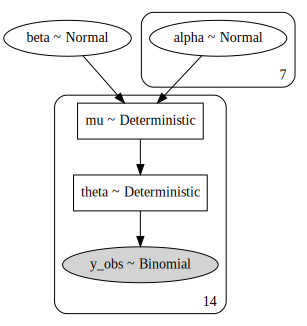

Model 2:


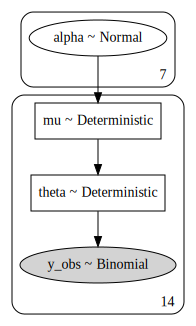

In [10]:
print("Model 1:")
display(pm.model_to_graphviz(model_1_edu))
print("Model 2:")
display(pm.model_to_graphviz(model_2_edu))

Running our sampler on these modified models produces the following results:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta]
100%|██████████| 1000/1000 [00:02<00:00, 465.82it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rv

Model 1:


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


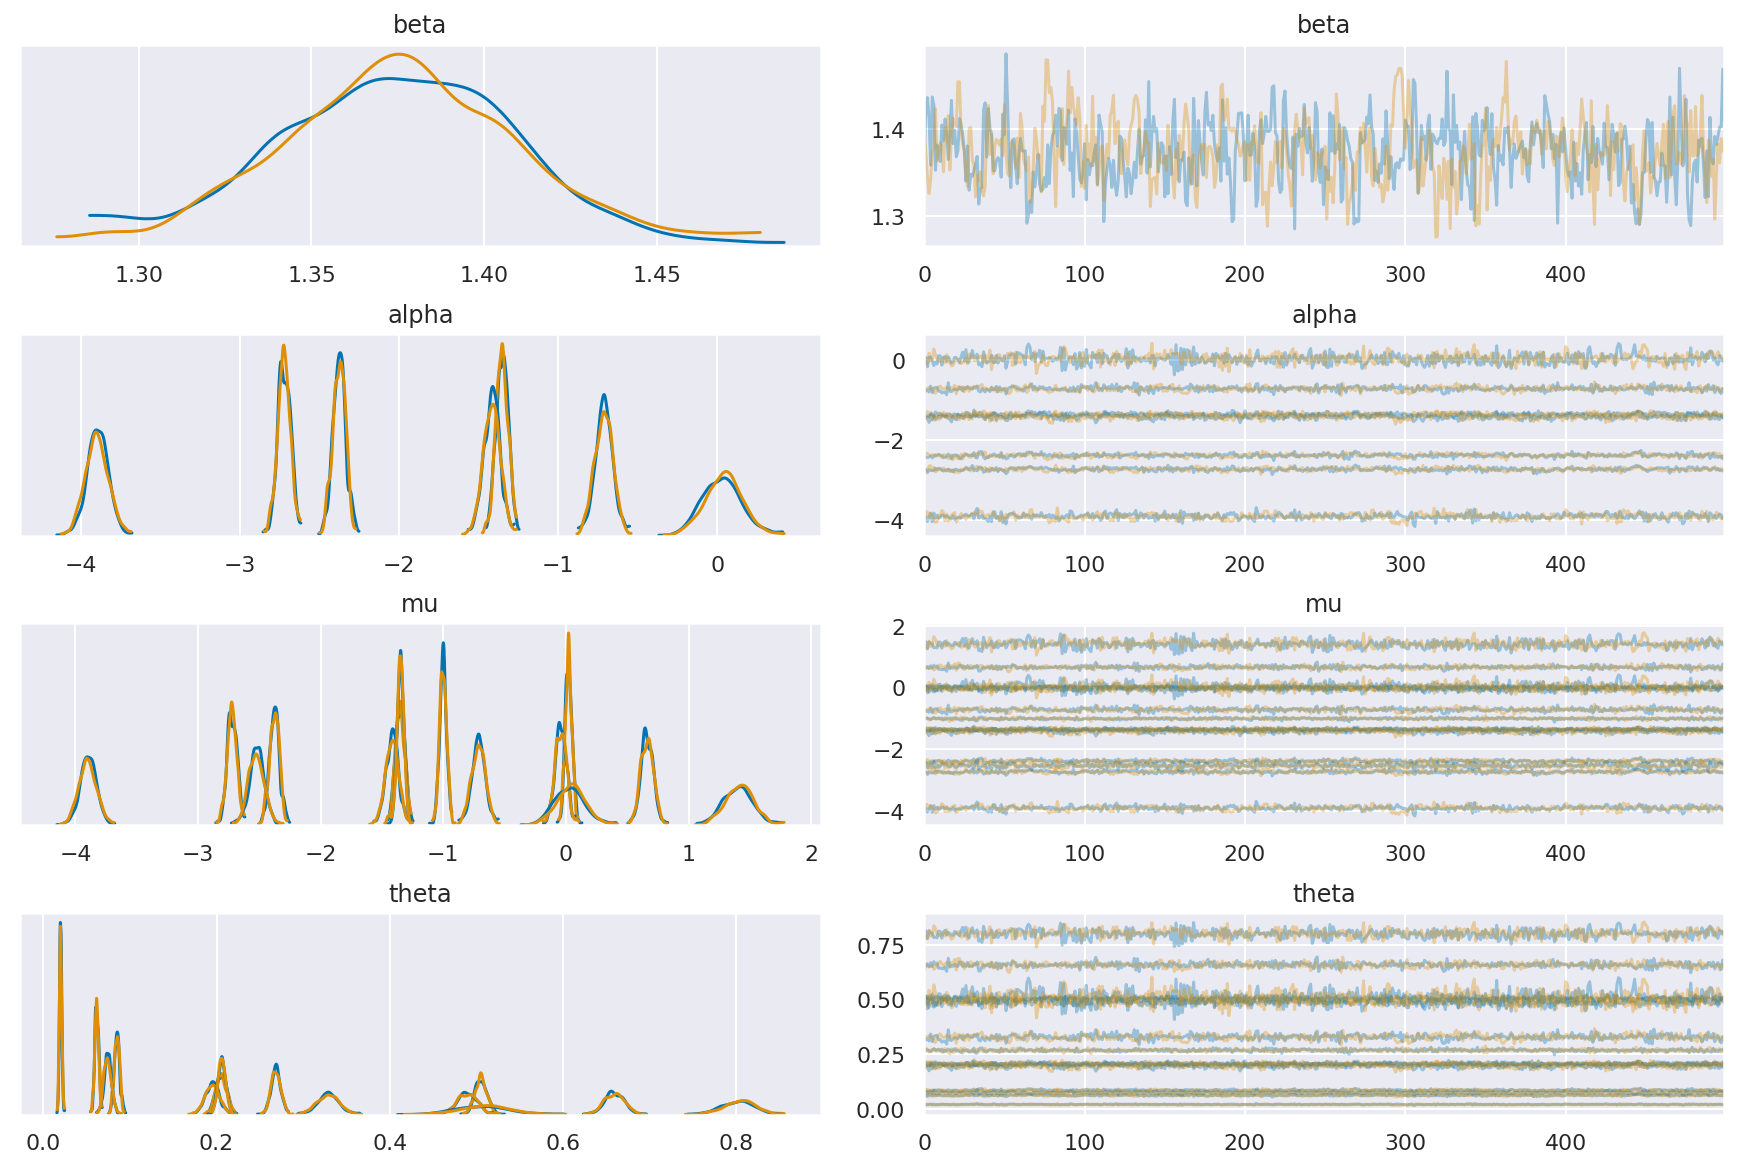

Model 2:


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


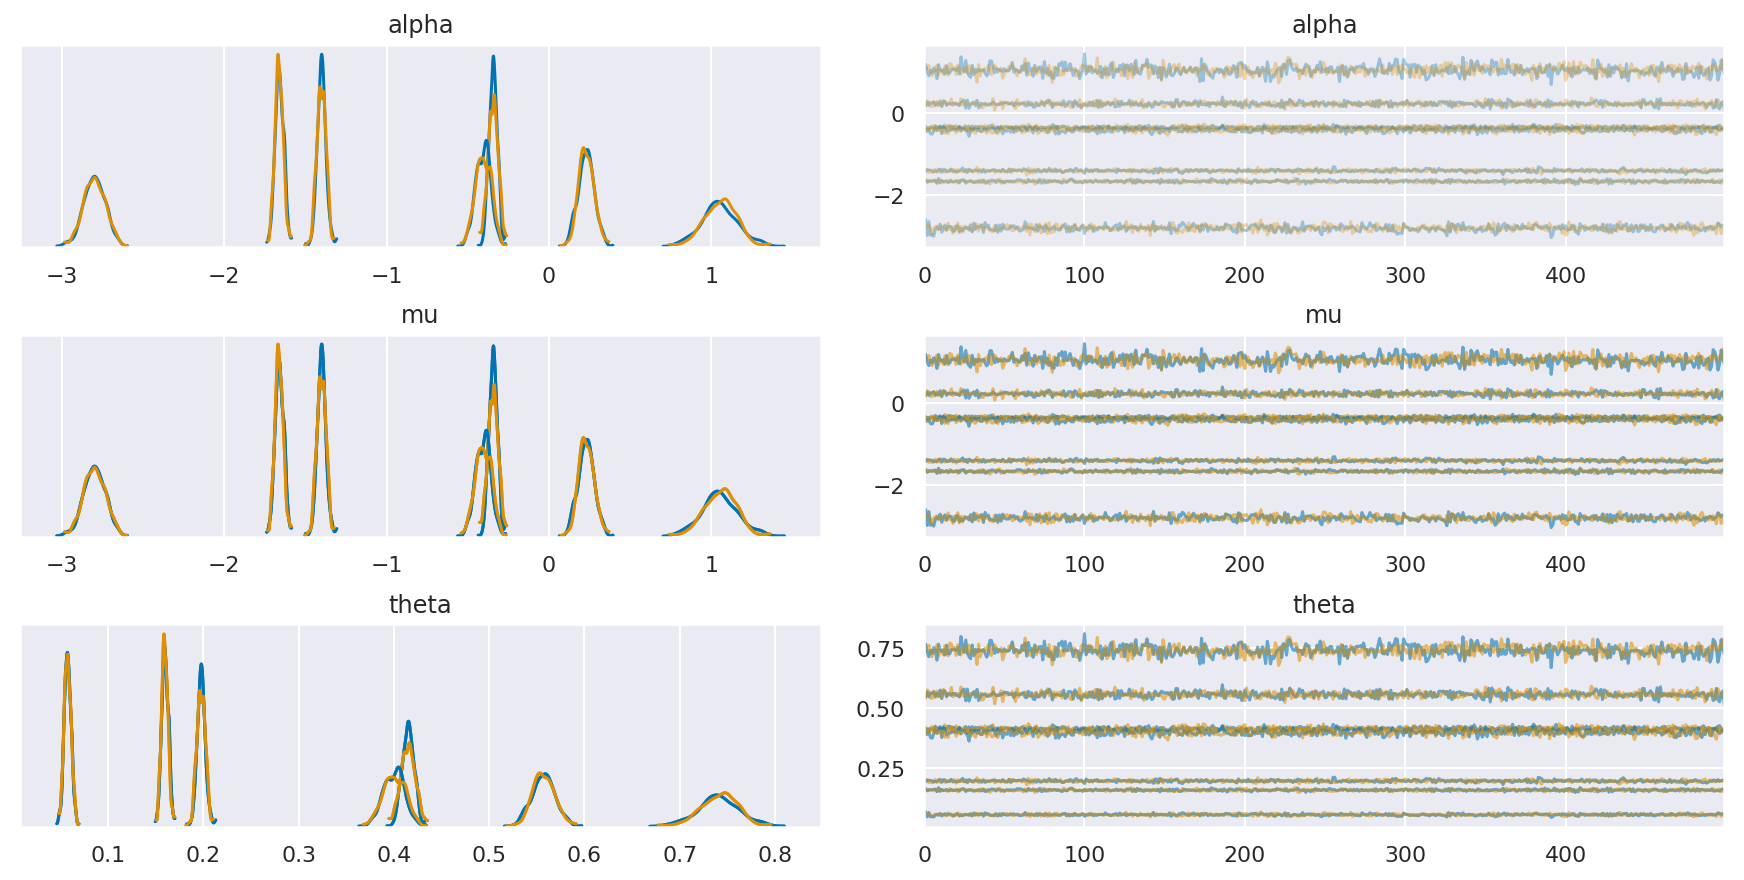

In [11]:
# run sampler on each model
with model_1_edu:
    trace_1_edu = pm.sample(500, tune=500)
with model_2_edu:
    trace_2_edu = pm.sample(500, tune=500)

# display trace results
print("Model 1:")
pm.traceplot(trace_1_edu, var_names=["beta", "alpha", "mu", "theta"], compact=True)
plt.show()
print("Model 2:")
pm.traceplot(trace_2_edu, var_names=["alpha", "mu", "theta"], compact=True)
plt.show()

We can now see peaks forming around each education category, which we can now analyze in finer-grained detail than in Part I. The Widely-applicable Information Criterion (WAIC) for each model is:

In [12]:
print("Model 1:")
print(pm.waic(trace_1_edu, model_1_edu).WAIC)
print("Model 2:")
print(pm.waic(trace_2_edu, model_2_edu).WAIC)

Model 1:


/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


123.1099651131158
Model 2:
2909.9948549994265


The WAIC for Model 1 is now significanly smaller than the one for Model 2. Our modification seems to be fitting the data better!

#### 2.2 Posterior Predictive Plot

Taking a look at the posterior predictive next we see the following for each model:

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 500/500 [00:01<00:00, 424.46it/s]


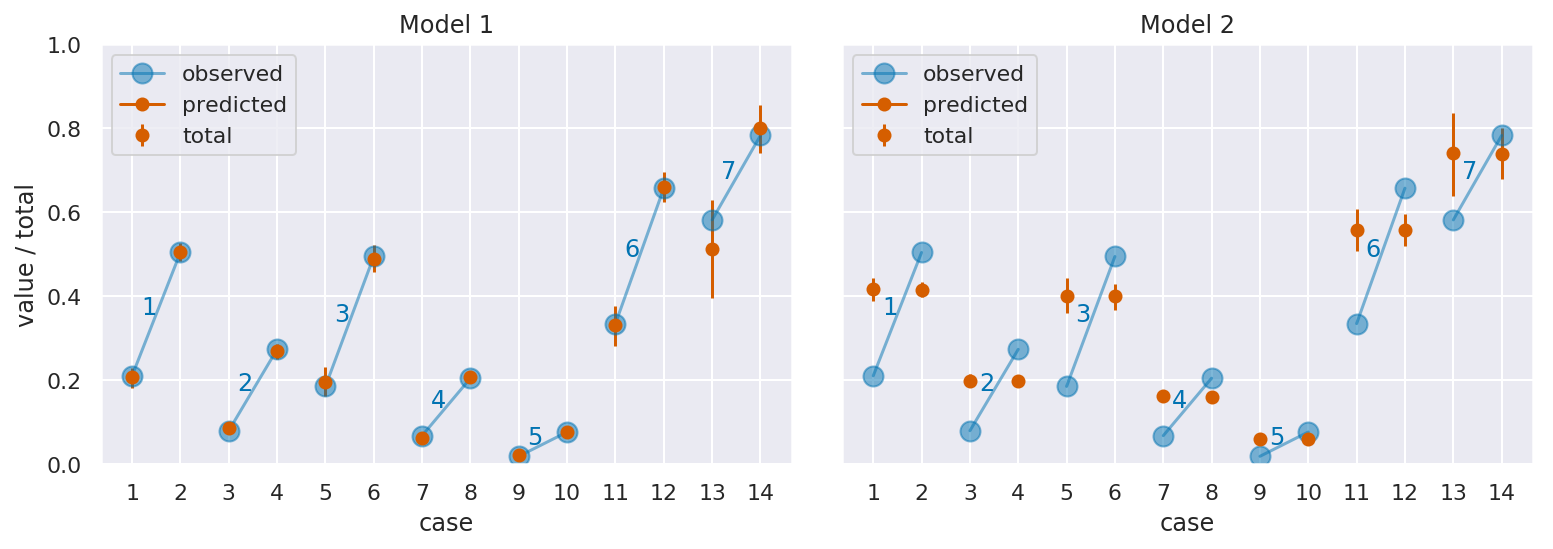

In [13]:
# compute posterior predictive
ppc_1_edu = pm.sample_posterior_predictive(trace_1_edu, samples=500,
                                       model=model_1_edu)
ppc_2_edu = pm.sample_posterior_predictive(trace_2_edu, samples=500,
                                       model=model_2_edu)

# create plot similar to Fig. 10.5 in Statistical Rethinking
fig, axes = plt.subplots(1, 2, figsize=fig_wide, sharey=True)

x = range(len(df)) # for indexed errorbar plotting
# Model 1
#plot_connected(axes[0], np.mean(ppc_1["y_obs"], axis=0) / df["total"], c='r')
model_1_means, model_1_errs = get_ci_array(ppc_1_edu["y_obs"])
model_1_means /= df["total"] # convert to percentage
model_1_errs /= df["total"][None, :]
axes[0].errorbar(x, model_1_means, yerr=model_1_errs, fmt="o", c='r')

axes[0].set_ylabel("value / total")
axes[0].set_title("Model 1")

# Model 2
#plot_connected(axes[1], np.mean(ppc_2["y_obs"], axis=0) / df["total"], c='r')
model_2_means, model_2_errs = get_ci_array(ppc_2_edu["y_obs"])
model_2_means /= df["total"] # convert to percentage
model_2_errs /= df["total"][None, :]
axes[1].errorbar(x, model_2_means, yerr=model_2_errs, fmt="o", c='r')
axes[1].set_title("Model 2")

for ax in axes:
    plot_connected(ax, df[">50"] / df["total"], color='b', alpha=0.5, ms=10)
    ax.plot([], "b-o", alpha=0.5, label="observed", ms=10)
    ax.plot([], "r-o", label="predicted")
    ax.set_xticks(np.arange(0, len(df)))
    ax.set_xticklabels(range(1, len(df)+1))
    ax.set_xlabel("case")
    ax.set_ylim(0, 1)
    ax.legend(loc=2)

fig.tight_layout()

The model looks to fit the data much better now, especially for Model 1. It seems more evident now that marriage status does play a role in income level, but not as large of a role as education level.

### Part III: Comparison of All Models

1. Based on your analysis above, what can you say about the effect of marital status on an individual's income? Point to evidence that supports what you are claiming.

Based on the analysis above, it looks like marital status and education are very correlated with income level, with education being the dominant factor. Across the board for education, being married looks to correlate with a high income for a given education level. 

The introduction of an individual alpha for each category allowed us to have finer grained inference of our uncertainties (due to the lower WAIC scores and posterior predictives consistent with observation) when trying to make sweeping inferences from a wide range of categorical data.